Right, so let's keep working on this topography stuff. We know that the `topog_raw.nc` has the most accurate topography. However it also has lakes that need to be removed. Meanwhile, the "deseas'd" topography has too much land. 

Remembering the tests I was doing with vertical coordinate, the shallowest layer was still around 10m or something. Making changes to this, I was able to get the shallowest layer down to about 1m. We'll try with this, and then change things if even that is too deep. 

So, let's pull in the relevant input files from `sharkbay_iaf`. Then see if there's any changes we can make...

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40545,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:38921,Total threads: 1
Dashboard: /proxy/41707/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:40485,


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'elevation' has multiple fill values {1e+20, -1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


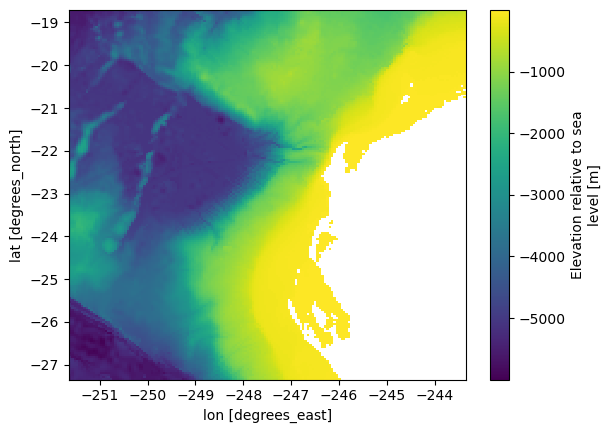

In [2]:
inputdir = "/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf"
topog = xr.open_dataset(f"{inputdir}/topog_raw.nc")
depth = topog['elevation'].where(topog['elevation']<=0, drop=False)
depth.plot()

So the challenge now is to mask out the lakes, as well as set a vertical coordinate that can allow for the coastline to be represented accurately. 

Let's first look into the land masking / deseas approach...

To do this, we'll have to break down the bathymetry approach...

In [ ]:
        ## reopen topography to modify
        topog = xr.open_dataset(self.mom_input_dir + "topog_raw.nc")

        ## Ensure correct encoding
        topog = xr.Dataset(
            {"depth":(["ny","nx"],topog[varnames["elevation"]].values)}
        )
        topog.attrs["depth"] = "meters"
        topog.attrs["standard_name"] = "topographic depth at T-cell centers"
        topog.attrs["coordinates"] = "zi"

        topog.expand_dims("tiles",0)

        if topog.depth.mean() < 0:
            ## Ensure that coordinate is positive down!
            topog["depth"] *= -1


        ## REMOVE INLAND LAKES
        
        min_depth = self.vgrid.zi[minimum_layers]

So, here the topog_raw is opened, and the relevant attributes and structure are set. Interestingly, as the topog dataset is "elevation", the ocean is negative which apparently cannot be handled. 

Then to the important bit: `min_depth = self.vgrid.zi[minimum_layers]`. `minimum_layers` is an argument given to this bathymetry method. I'm not entirely sure why the default is 3 and will have to check that with Ashley. Is it perhaps that circulation cannot be represented with less than three layers? If we do go ahead with the very high shallow resolution and coarser deep resolution, than the "minimum_layers" == 3 shouldn't be a problem and we should still end up with something that should look reasonable for the coastline. 

Let's look at the vgrid and make some adjustments...

In [60]:
    def _make_vgrid(vlayers, dz_ratio, depth, mom_input_dir):
        """
        Generates a vertical grid based on the number of layers and vertical ratio specified at the class level.
        """
        thickness = dz(vlayers+1,dz_ratio,depth)
        vcoord = xr.Dataset(
            {"zi":("zi",np.cumsum(thickness)),
             "zl":("zl",(np.cumsum(thickness) + 0.5 * thickness)[0:-1])} ## THIS MIGHT BE WRONG REVISIT
        )
        vcoord["zi"].attrs = {"units":"meters"}
        vcoord.to_netcdf(mom_input_dir + "/vcoord.nc")

        return vcoord


In [61]:
def dz(npoints,ratio,target_depth,min_dz = 0.0001,tolerence = 0.001):
    """
    Recursive function takes the target depth, the ratio between largest and smallest layer thicknesses, and generates a hyperbolic tangent thickness profile for the experiment.
    Iterates to find the mininum depth value which gives the target depth within some tolerence

            Parameters:
                npoints (int):           Number of vertical points
                ratio (float):           Ratio of largest to smallest layer thickness. Negative values mean higher resolution is at bottom
                target_depth (float):    Maximum depth of a layer
                min_dz (float):          Starting point for iteration
                tolerence (float):       How close to target depth you want to get

            Returns:
                numpy array of layer thicknesses

    """
    profile = min_dz + 0.5 *  (np.abs(ratio) * min_dz - min_dz) * (1 + np.tanh(2 * np.pi * (np.arange(npoints) - npoints // 2) / npoints))
    tot = np.sum(profile)
    if np.abs(tot - target_depth) < tolerence:
        if ratio > 0:
            return profile

        return profile[::-1]

    err_ratio = target_depth / tot

    return dz(npoints,ratio,target_depth,min_dz * err_ratio)

In [10]:
vgrid_ls = []

In [63]:
test_vgrid = _make_vgrid(vlayers=100, dz_ratio=30, depth=3000, mom_input_dir=inputdir)
test_vgrid

<xarray.Dataset>
Dimensions:  (zi: 101, zl: 100)
Coordinates:
  * zi       (zi) float64 2.027 4.068 6.125 8.202 ... 2.885e+03 2.943e+03 3e+03
  * zl       (zl) float64 3.04 5.088 7.154 ... 2.857e+03 2.914e+03 2.971e+03
Data variables:
    *empty*

In [64]:
vgrid_ls.append(test_vgrid)

(-0.5, 2.2)

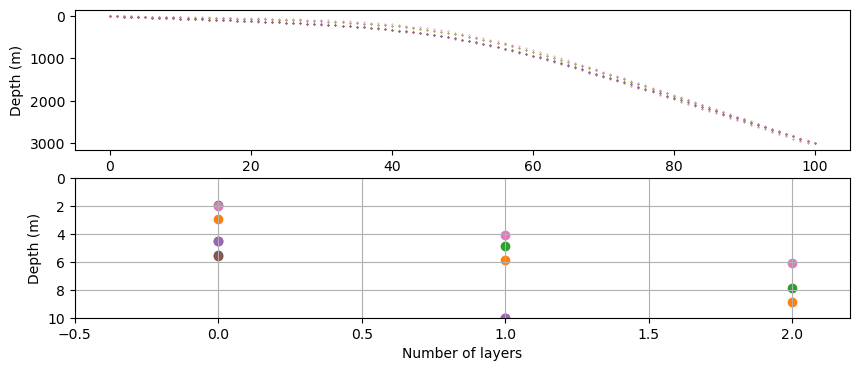

In [65]:
fig, ax = plt.subplots(2,1, figsize=(10,4))

for v in vgrid_ls:
    ax[0].scatter(np.arange(len(v['zi']-1)), v['zi'], s=0.1)
    ax[1].scatter(np.arange(5), v['zi'][:5])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_xlabel('Number of layers')
ax[1].grid()
ax[1].set_ylim(10,0)
ax[1].set_xlim(-0.5,2.2)

Let's instead using Kials approach, that way we can get much closer to the land I feel. Then we can talk to Ash about his approach later.

In [66]:
!python vertical_grid_for_ocean_models/build_vertical_grid_kds.py --H 3000 --dzd 200

SUCCESS!! You now have a vertical grid of  101  levels with grid spacing ranging from  0.0  to  197.39128094439255  written to files  vgrid_supergrid.nc  and  vgrid_st_ocean.nc


In [3]:
os.getcwd()

'/home/581/jr5971'

In [4]:
inputdir

'/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf'

In [6]:
import subprocess

In [9]:
vgrid_toolpath = '/home/581/jr5971/vertical_grid_for_ocean_models/build_vertical_grid_kds.py'
args = "--H 4000 --dzd 200 --min_dz 1.0 --depfac 1.2 --super_grid_filename super_vgrid.nc --regular_grid_filename ocean_vgrid.nc".split(',')

subprocess.run(['python', vgrid_toolpath, args])

TypeError: expected str, bytes or os.PathLike object, not list

In [73]:
args

['--H',
 '4000',
 '--dzd',
 '200',
 '--min_dz',
 '1.0',
 '--depfac',
 '1.2',
 '--super_grid_filename',
 'super_vgrid.nc',
 '--regular_grid_filename',
 'ocean_vgrid.nc']